In [123]:
import pandas as pd
import numpy as np



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam
from datetime import datetime


from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score


In [124]:
#Load dataset into a pandas dataframe
data = pd.read_csv("../data/Cleaned data/data.csv") 

data.dropna(inplace = True)

data.head()

,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,MIN,MAX,RAIN,SOLAR,RRP,FORECASTDEMAND,OUTPUT,MONTHDATE,WEEKDAY,WEEKEND,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,15.3,28.6,0.0,32.2,38.472917,6665.366167,23.465,01-2016,4,0,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,15.9,26.1,0.0,21.7,36.907292,6236.849955,23.465,01-2016,5,1,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,17.5,25.6,0.0,10.3,31.997083,6551.924748,23.465,01-2016,6,1,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,18.2,23.6,14.0,6.4,33.424583,6729.993123,23.465,01-2016,0,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,17.6,20.5,39.0,4.4,33.053958,7333.898202,23.465,01-2016,1,0,19.05


In [125]:

df = data.drop(['MIN','MAX','FORECASTDEMAND', 'MONTHDATE','WEEKEND','RAIN'], axis=1)

#y = df['FORECASTDEMAND']

df.head()


,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,WEEKDAY,TEMPAVE
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,38.472917,23.465,4,21.95
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,36.907292,23.465,5,21.00
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,31.997083,23.465,6,21.55
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,33.424583,23.465,0,20.90
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,33.053958,23.465,1,19.05


In [126]:
# Onehot Encoding for categorial data (Weekday)


# Select the "WEEKDAY" column and create a new dataframe
weekday_df = df[['WEEKDAY']]

# Create a one-hot encoder object

encoder = OneHotEncoder(categories='auto')

# Fit and transform the weekday data
weekday_encoded = encoder.fit_transform(df[['WEEKDAY']]).toarray()

# Create a new dataframe with the encoded weekday data
weekday_df = pd.DataFrame(weekday_encoded, columns=['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'])

#Drop weekday column
df = df.drop(['WEEKDAY'], axis=1)

# Concatenate the original dataframe with the encoded weekday dataframe
df = pd.concat([df, weekday_df], axis=1)


df.head()




,YEAR,MONTH,DAY,HUMIDITY,WINDSPEED,DATE,TOTALDEMAND,HOLIDAY,SOLAR,RRP,OUTPUT,TEMPAVE,MON,TUE,WED,THU,FRI,SAT,SUN
0,2016,1,1,0.656341,15.902439,2016-01-01,6853.633437,2.0,32.2,38.472917,23.465,21.95,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2016,1,2,0.656341,15.902439,2016-01-02,6727.613958,0.0,21.7,36.907292,23.465,21.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2016,1,3,0.688837,14.488372,2016-01-03,6616.406076,0.0,10.3,31.997083,23.465,21.55,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2016,1,4,0.679545,22.477273,2016-01-04,7367.750278,0.0,6.4,33.424583,23.465,20.90,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016,1,5,0.768837,22.581395,2016-01-05,7462.242014,0.0,4.4,33.053958,23.465,19.05,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [127]:
# Convert the 'date' column to a datetime object
df['DATE'] = pd.to_datetime(df['DATE'])

# Set 'DATE' as the index
df.set_index('DATE', inplace=True)





In [128]:
# Split the dataset into training and testing sets. 

train_set = np.where((df.index >= datetime(2017, 8, 1)) & (df.index < datetime(2021, 8, 1)))[0]
test_set = np.where(df.index >= datetime(2021, 8, 1))[0]


# identify response variable and predictors

X = df.drop(['TOTALDEMAND'], axis=1).values
y = df['TOTALDEMAND'].values


In [129]:
# Normalize the data


scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_X.fit_transform(X[train_set])
X_test_scaled = scaler_X.transform(X[test_set])

scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler_y.fit_transform(y[train_set].reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y[test_set].reshape(-1, 1)).ravel()

print(X_train_scaled[:5])


[[0.         0.63636364 0.         0.5780574  0.48699955 0.
  0.4068323  0.7116133  0.10793701 0.32412791 0.         1.
  0.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.03333333 0.5780574  0.48699955 0.
  0.40372671 0.64976244 0.10793701 0.3255814  0.         0.
  1.         0.         0.         0.         0.        ]
 [0.         0.63636364 0.06666667 0.69542214 0.28363047 0.
  0.2826087  0.749493   0.10793701 0.39244186 0.         0.
  0.         1.         0.         0.         0.        ]
 [0.         0.63636364 0.1        0.87136016 0.12704281 0.
  0.41304348 0.68692824 0.10793701 0.35901163 0.         0.
  0.         0.         1.         0.         0.        ]
 [0.         0.63636364 0.13333333 0.52090236 0.44853191 0.
  0.42857143 0.55983012 0.10793701 0.34302326 0.         0.
  0.         0.         0.         1.         0.        ]]


In [130]:
#Reshape the data for input to the LSTM model
#(This step is fit the data to 3D tensor format for LSTM model to process the sequential data efficiently 
#and capture any temporal dependencies in the data)

#using sliding window approach to create input-output pairs with
#timesteps n = 1



X_train = []
y_train = []
for i in range(1, len(X_train_scaled)):
    X_train.append(X_train_scaled[i-1:i, :])
    y_train.append(X_train_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

X_test = []
y_test = []
for i in range(1, len(X_test_scaled)):
    X_test.append(X_test_scaled[i-1:i, :])
    y_test.append(X_test_scaled[i, 1])
X_test, y_test = np.array(X_test), np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_train.shape[2]))


#X_train.shape[0]
#X_train.shape[1]
#X_train.shape[2]



In [131]:
# Build the LSTM model with three LSTM layers and one Dense output layer


model = Sequential()
model.add(LSTM(units=128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))


optimizer = Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [132]:

# Train the LSTM model

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
46/46 [==============================] - 2s 12ms/step - loss: 0.3319 - val_loss: 0.3196
Epoch 2/100
46/46 [==============================] - 0s 3ms/step - loss: 0.2896 - val_loss: 0.2687
Epoch 3/100
46/46 [==============================] - 0s 3ms/step - loss: 0.2362 - val_loss: 0.2023
Epoch 4/100
46/46 [==============================] - 0s 3ms/step - loss: 0.1715 - val_loss: 0.1331
Epoch 5/100
46/46 [==============================] - 0s 3ms/step - loss: 0.1149 - val_loss: 0.1007
Epoch 6/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0907 - val_loss: 0.0978
Epoch 7/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0819 - val_loss: 0.0932
Epoch 8/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0753 - val_loss: 0.0858
Epoch 9/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0696 - val_loss: 0.0787
Epoch 10/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0701
Epoch 11

46/46 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 84/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 85/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0039
Epoch 86/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0064 - val_loss: 0.0037
Epoch 87/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 88/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 89/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0065 - val_loss: 0.0041
Epoch 90/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0062 - val_loss: 0.0039
Epoch 91/100
46/46 [==============================] - 0s 3ms/step - loss: 0.0066 - val_loss: 0.0043
Epoch 92/100
46/46 [==============================] - 0s 4ms/step - loss: 0.0060 - val_loss: 0.0039
Epoch 93/100


In [133]:
# Make predictions on the test set
y_pred = model.predict(X_test)


In [134]:
# Calculate MSE and R-squared

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE: %.4f' % mse)
print('R-squared: %.4f' % r2)

MSE: 0.0037
R-squared: 0.9649


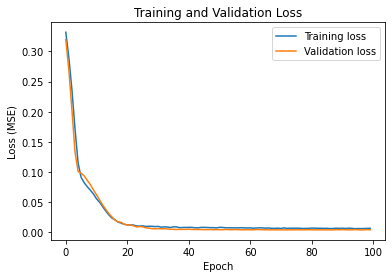

In [135]:


import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

# Plot training and validation loss (MSE) for each epoch
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()




Plot Accuracy

In [122]:

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import datetime as dt

